In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew, boxcox
from math import exp, log
import xgboost as xgb

In [3]:
train_loader = pd.read_csv('train.csv',dtype = {'id':np.int32})

In [4]:
train_loader.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [7]:
train = train_loader.drop(['id','loss'],axis = 1)

In [9]:
test_loader = pd.read_csv('test.csv',dtype={'id' : np.int32})

In [11]:
test = test_loader.drop(['id'],axis = 1)

In [12]:
ntrain = train.shape[0]
ntest = test.shape[0]

In [13]:
train_test = pd.concat((train,test))

In [17]:
train_test = train_test.reset_index(drop = True)

In [19]:
numeric_feats = train_test.dtypes[train_test.dtypes != "object"].index

In [21]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))

In [22]:
skewed_feats = skewed_feats[skewed_feats > 0.25]
skewed_feats = skewed_feats.index
for feats in skewed_feats:
    train_test[feats] = train_test[feats] + 1
    train_test[feats], lam = boxcox(train_test[feats])

In [23]:
features = train.columns
cats = [feat for feat in features if 'cat' in feat]

In [32]:
for feat in cats:
        train_test[feat] = pd.factorize(train_test[feat], sort=True)[0]

In [39]:
x_train = train_test.iloc[:ntrain, :]
x_test = train_test.iloc[ntrain:, :]
scaler = StandardScaler()
scaler.fit(train_test)
train = scaler.transform(x_train)
test = scaler.transform(x_test)

In [40]:
train_labels = np.log(np.array(train_loader['loss']))
train_ids = train_loader['id'].values.astype(np.int32)
test_ids = test_loader['id'].values.astype(np.int32)

In [61]:
from sklearn.metrics import mean_squared_error

In [68]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['loss'])

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['loss'], cv=cv_folds, scoring='mean_squared_error')

    #Print model report:
    print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['loss'].values, dtrain_predictions)
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['loss'], dtrain_predprob)

    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [63]:
predictors = [x for x in x_train.columns if x != 'loss']

In [67]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [65]:
gbm0 = GradientBoostingRegressor(random_state = 10)


Model Report
CV Score : Mean - -0.316475 | Std - 0.002282835 | Min - -0.3197639 | Max - -0.31394


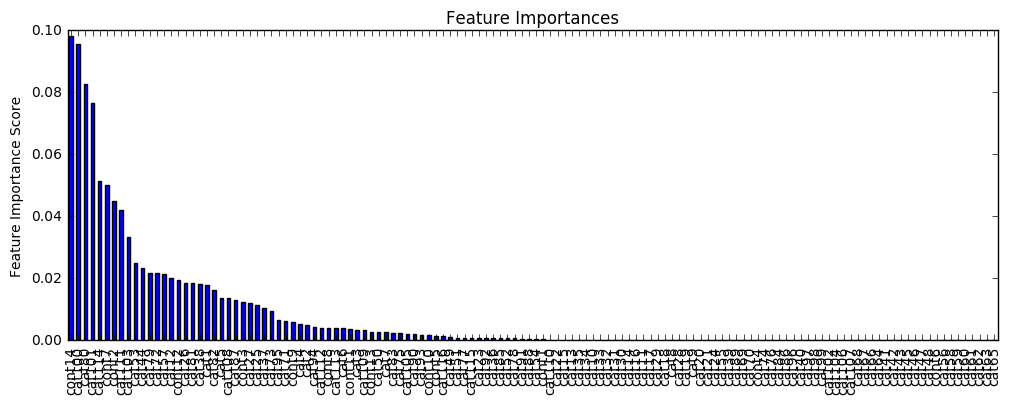

In [69]:
modelfit(gbm0,x_train,predictors)

In [73]:
dtrain_predictions = gbm0.predict(x_train[predictors])

In [74]:
dtrain_predictions

array([ 7.62374003,  7.49512707,  8.3252417 , ...,  8.25434642,
        8.03062305,  7.67639971])

In [82]:
metrics.mean_absolute_error(dtrain_predictions,x_train['loss'])

0.4372391315577645

In [84]:
from sklearn.metrics import mean_absolute_error

In [86]:
param_test1 = {'n_estimators':range(20,150,20)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test1, scoring='mean_absolute_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_train[predictors],x_train['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=8, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=50, min_samples_split=500,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 40, 60, 80, 100, 120, 140]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [87]:
gsearch1.grid_scores_,gsearch1.best_params_,gsearch1.best_score_

([mean: -0.46723, std: 0.00160, params: {'n_estimators': 20},
  mean: -0.43718, std: 0.00158, params: {'n_estimators': 40},
  mean: -0.42838, std: 0.00176, params: {'n_estimators': 60},
  mean: -0.42476, std: 0.00198, params: {'n_estimators': 80},
  mean: -0.42274, std: 0.00199, params: {'n_estimators': 100},
  mean: -0.42137, std: 0.00194, params: {'n_estimators': 120},
  mean: -0.42050, std: 0.00202, params: {'n_estimators': 140}],
 {'n_estimators': 140},
 -0.42049644578991252)